# Individual Assignment

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import seaborn as sns
sns.set(style="darkgrid")
from time import time

from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import OneHotEncoder
from sklearn.metrics import make_scorer
from sklearn.metrics import fbeta_score
from sklearn.metrics import accuracy_score
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.svm import SVC
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA    


%matplotlib inline

In [2]:
import os
os.getcwd()

'C:\\Users\\jjpoh\\Documents\\NTU\\CET182 Introduction to Data Mining\\Individual Assignment'

In [3]:
path = "C:/Users/jjpoh/Documents/NTU/CET182 Introduction to Data Mining/Individual Assignment/Data/census+income"
os.chdir(path)

In [4]:
#Add the Table Name

columns=['Age','WorkClass','FinalWeight','Education','EducationNumber','MaritalStatus','Occupation','Relationship','Race','Sex','CapitalGain','CapitalLost','HoursPerWeek','NativeCountry','Income']

In [5]:
ad_train = pd.read_csv('adult.data', header=None, names=columns, skipinitialspace=True)

# Drop the FinalWeight column which is useless for later analysis
ad_train = ad_train.drop('FinalWeight', axis=1)

# Display several rows and shape of data set
display(ad_train.head())
display(ad_train.shape)

,Age,WorkClass,Education,EducationNumber,MaritalStatus,Occupation,Relationship,Race,Sex,CapitalGain,CapitalLost,HoursPerWeek,NativeCountry,Income
0,39,State-gov,Bachelors,13,Never-married,Adm-clerical,Not-in-family,White,Male,2174,0,40,United-States,<=50K
1,50,Self-emp-not-inc,Bachelors,13,Married-civ-spouse,Exec-managerial,Husband,White,Male,0,0,13,United-States,<=50K
2,38,Private,HS-grad,9,Divorced,Handlers-cleaners,Not-in-family,White,Male,0,0,40,United-States,<=50K
3,53,Private,11th,7,Married-civ-spouse,Handlers-cleaners,Husband,Black,Male,0,0,40,United-States,<=50K
4,28,Private,Bachelors,13,Married-civ-spouse,Prof-specialty,Wife,Black,Female,0,0,40,Cuba,<=50K


(32561, 14)

In [6]:
# Read in test data
ad_test = pd.read_csv('adult.data', header=None, skiprows=1, names=columns, skipinitialspace=True)

ad_test = ad_test.drop('FinalWeight', axis=1)

# Remove '.' in income column
ad_test['Income'] = ad_test['Income'].apply(lambda x: '>50K' if x=='>50K.' else '<=50K')

# Review several rows and shape of data set
display(ad_test.head())
display(ad_test.shape)

,Age,WorkClass,Education,EducationNumber,MaritalStatus,Occupation,Relationship,Race,Sex,CapitalGain,CapitalLost,HoursPerWeek,NativeCountry,Income
0,50,Self-emp-not-inc,Bachelors,13,Married-civ-spouse,Exec-managerial,Husband,White,Male,0,0,13,United-States,<=50K
1,38,Private,HS-grad,9,Divorced,Handlers-cleaners,Not-in-family,White,Male,0,0,40,United-States,<=50K
2,53,Private,11th,7,Married-civ-spouse,Handlers-cleaners,Husband,Black,Male,0,0,40,United-States,<=50K
3,28,Private,Bachelors,13,Married-civ-spouse,Prof-specialty,Wife,Black,Female,0,0,40,Cuba,<=50K
4,37,Private,Masters,14,Married-civ-spouse,Exec-managerial,Wife,White,Female,0,0,40,United-States,<=50K


(32560, 14)

# Assessing missing data

In [7]:
ad_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 32561 entries, 0 to 32560
Data columns (total 14 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   Age              32561 non-null  int64 
 1   WorkClass        32561 non-null  object
 2   Education        32561 non-null  object
 3   EducationNumber  32561 non-null  int64 
 4   MaritalStatus    32561 non-null  object
 5   Occupation       32561 non-null  object
 6   Relationship     32561 non-null  object
 7   Race             32561 non-null  object
 8   Sex              32561 non-null  object
 9   CapitalGain      32561 non-null  int64 
 10  CapitalLost      32561 non-null  int64 
 11  HoursPerWeek     32561 non-null  int64 
 12  NativeCountry    32561 non-null  object
 13  Income           32561 non-null  object
dtypes: int64(5), object(9)
memory usage: 3.5+ MB


In [8]:
object_col = ad_train.select_dtypes(include=object).columns.tolist()
for col in object_col:
    print(ad_train[col].value_counts(dropna=False)/ad_train.shape[0],'\n')

Private             0.697030
Self-emp-not-inc    0.078038
Local-gov           0.064279
?                   0.056386
State-gov           0.039864
Self-emp-inc        0.034274
Federal-gov         0.029483
Without-pay         0.000430
Never-worked        0.000215
Name: WorkClass, dtype: float64 

HS-grad         0.322502
Some-college    0.223918
Bachelors       0.164461
Masters         0.052916
Assoc-voc       0.042443
11th            0.036086
Assoc-acdm      0.032769
10th            0.028654
7th-8th         0.019840
Prof-school     0.017690
9th             0.015786
12th            0.013298
Doctorate       0.012684
5th-6th         0.010227
1st-4th         0.005160
Preschool       0.001566
Name: Education, dtype: float64 

Married-civ-spouse       0.459937
Never-married            0.328092
Divorced                 0.136452
Separated                0.031479
Widowed                  0.030497
Married-spouse-absent    0.012837
Married-AF-spouse        0.000706
Name: MaritalStatus, dtype: float

In [9]:
# Convert '?' to NaNs and remove the NaN value
for col in object_col:
    ad_train.loc[ad_train[col]=='?', col] = np.nan
    ad_test.loc[ad_test[col]=='?', col] = np.nan

# Perform an missing assessment in each column of the dataset.
col_missing_pct = ad_train.isna().sum()/ad_train.shape[0]
col_missing_pct.sort_values(ascending=False)

Occupation         0.056601
WorkClass          0.056386
NativeCountry      0.017905
Income             0.000000
HoursPerWeek       0.000000
CapitalLost        0.000000
CapitalGain        0.000000
Sex                0.000000
Race               0.000000
Relationship       0.000000
MaritalStatus      0.000000
EducationNumber    0.000000
Education          0.000000
Age                0.000000
dtype: float64

In [10]:
ad_train = ad_train.dropna(axis=0, how='any')
ad_test = ad_test.dropna(axis=0, how='any')

print("Training set has {} samples.".format(ad_train.shape[0]))
print("Testing set has {} samples.".format(ad_test.shape[0]))

Training set has 30162 samples.
Testing set has 30161 samples.


C:\Users\jjpoh\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


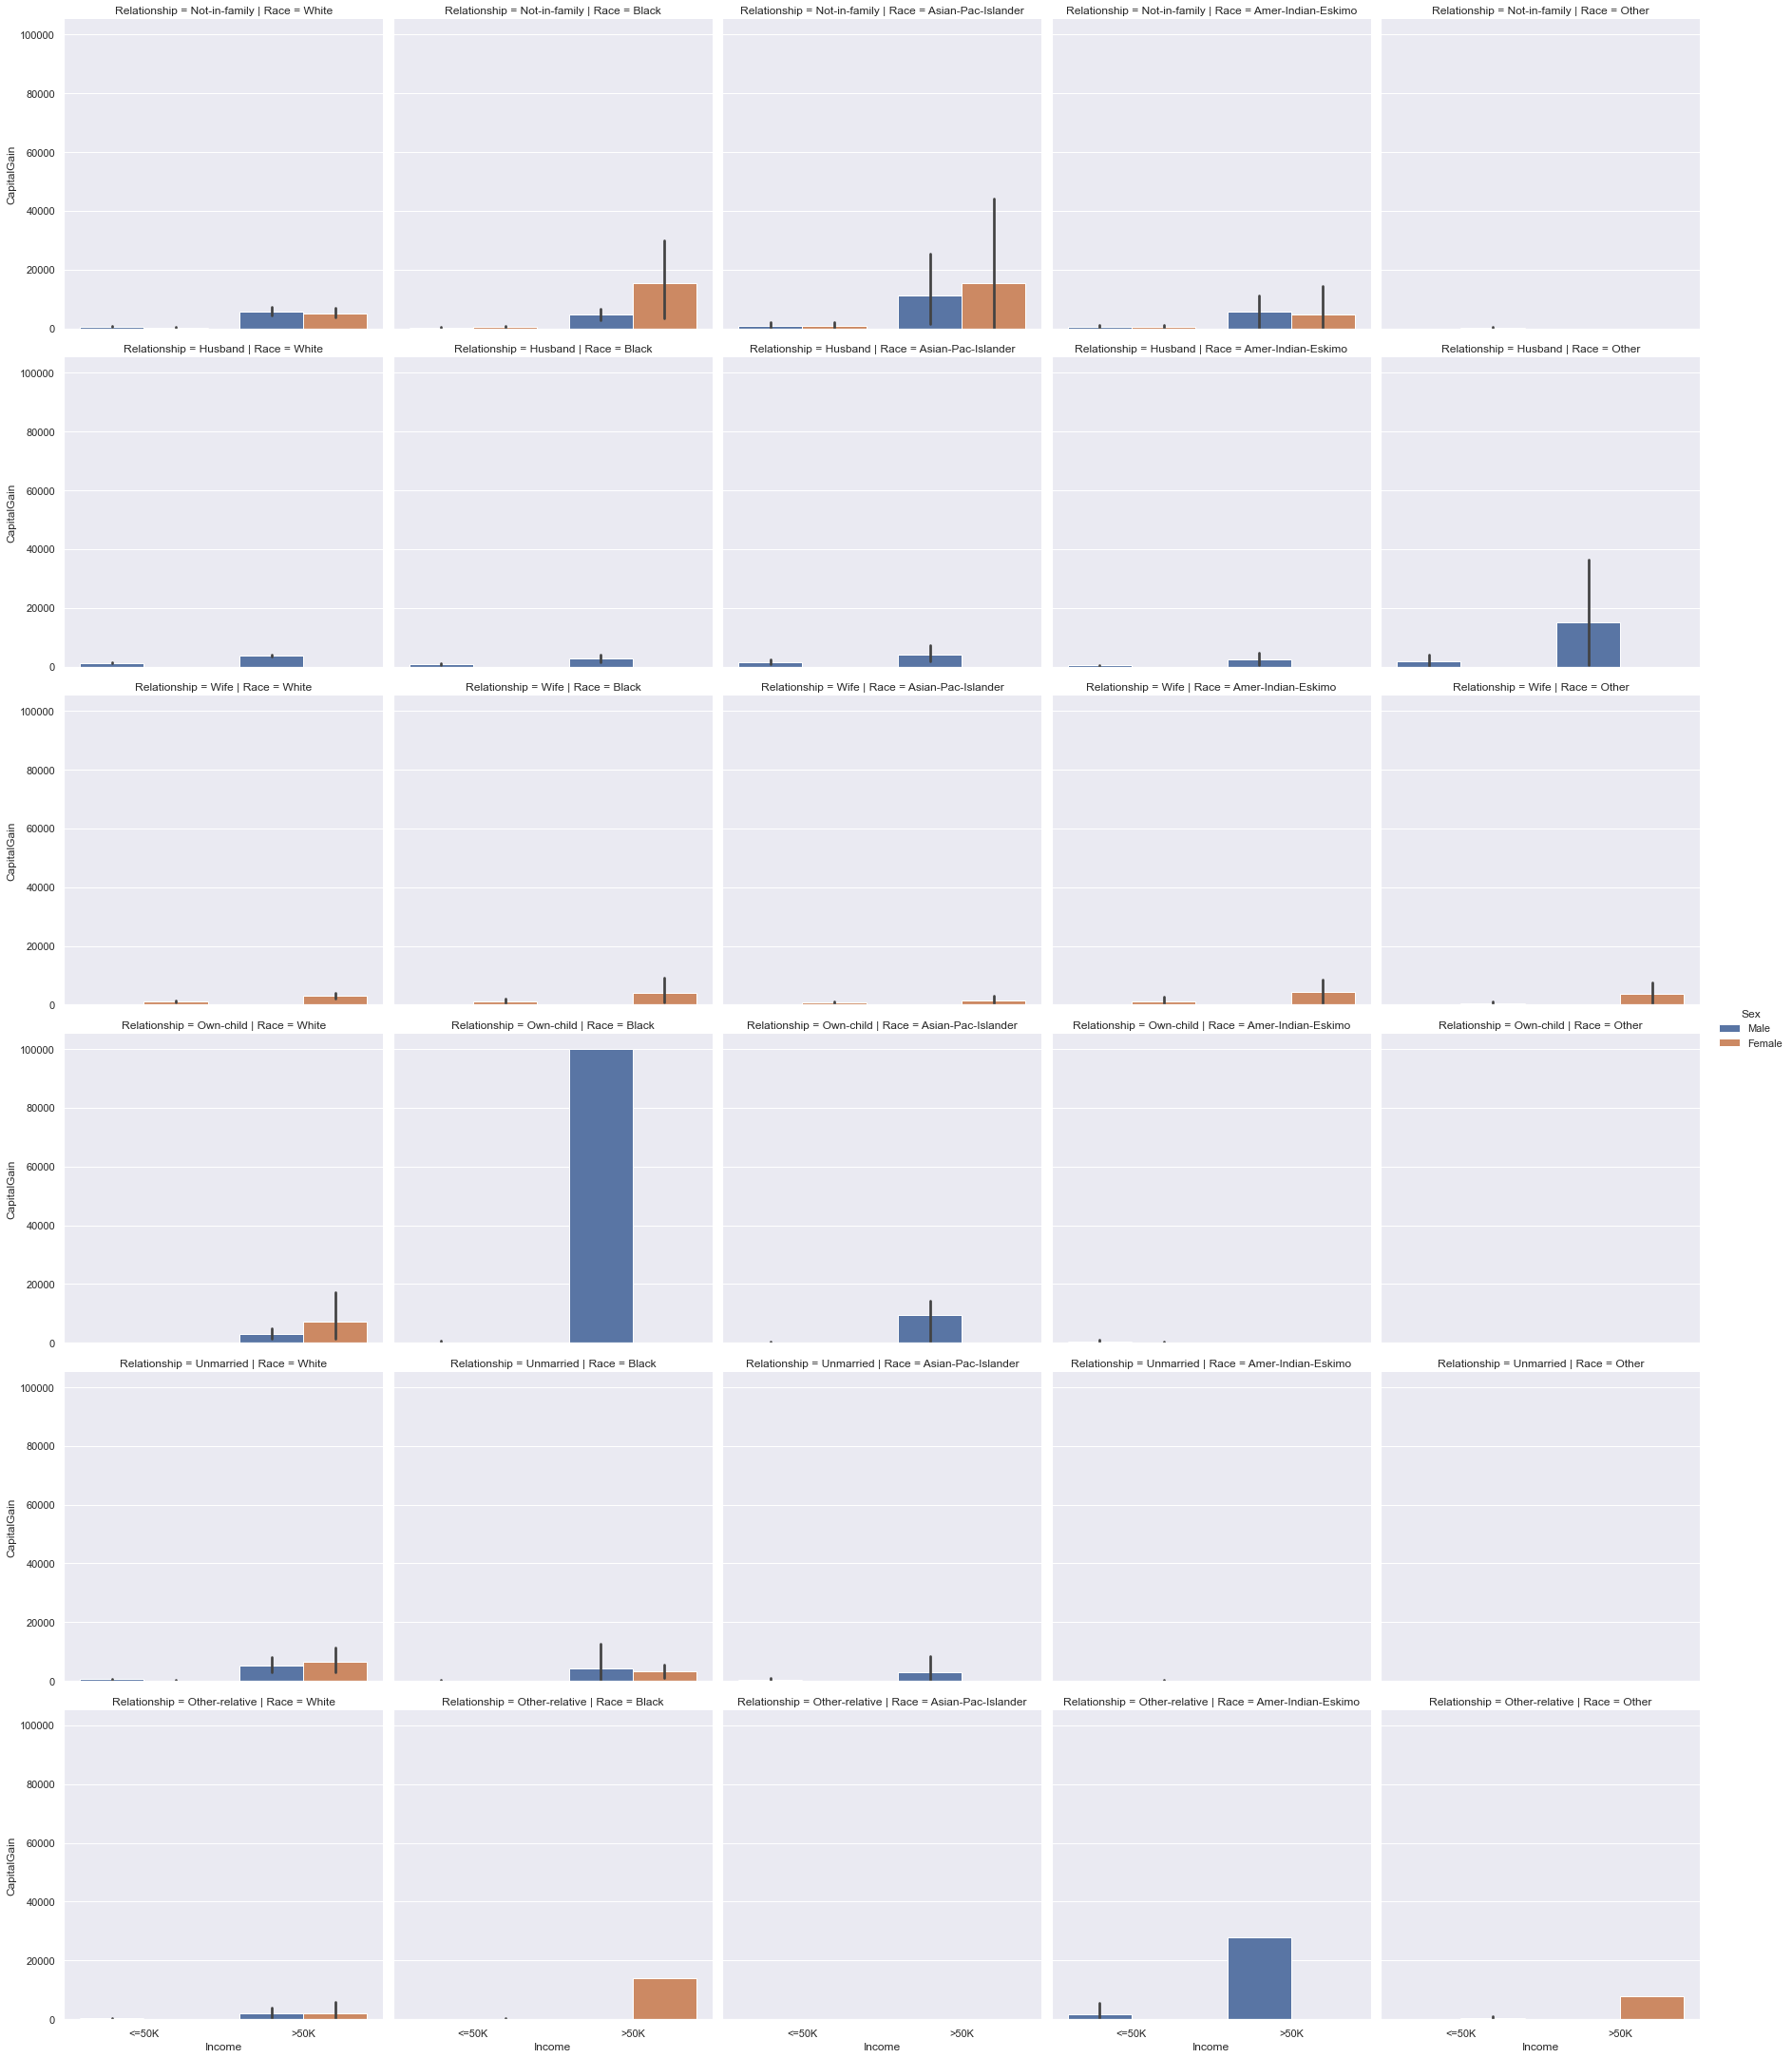

In [11]:
ad_data = pd.concat([ad_train, ad_test])

# Overview of the Data
sns.catplot('Income', 'CapitalGain', hue='Sex', data=ad_data, kind='bar', col='Race', row='Relationship')

<ipython-input-12-b63aafe6b1dd>:27: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax[0].set_yticklabels(map('{:.1f}%'.format, 100*ax[0].yaxis.get_majorticklocs()/total_F))
<ipython-input-12-b63aafe6b1dd>:28: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax[1].set_yticklabels(map('{:.1f}%'.format, 100*ax[1].yaxis.get_majorticklocs()/total_M))
<ipython-input-12-b63aafe6b1dd>:38: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


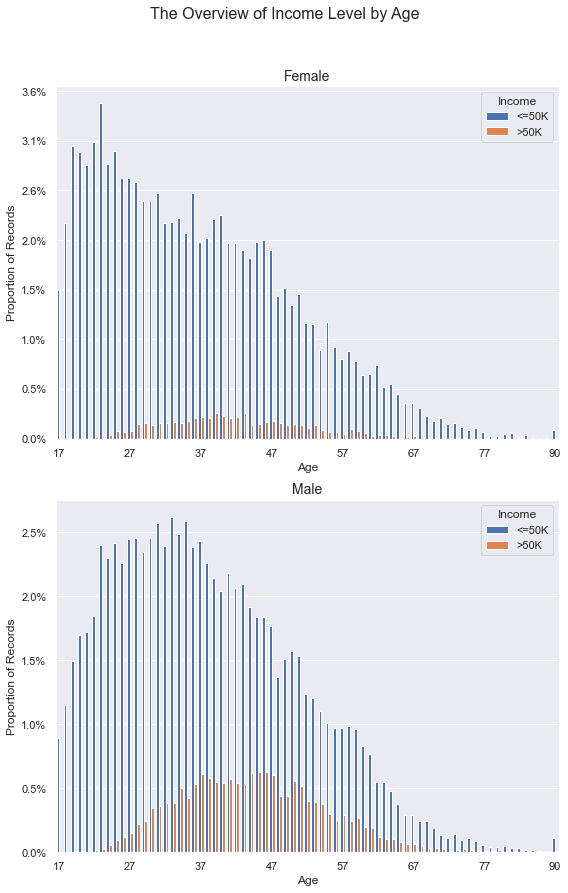

In [12]:
fig, ax =plt.subplots(2,1, figsize = (8, 12))

# Initiate plot
sns.countplot(x = 'Age', hue = 'Income', data = ad_data[ad_data.Sex=='Female'], saturation=1, ax=ax[0])
sns.countplot(x = 'Age', hue = 'Income', data = ad_data[ad_data.Sex=='Male'], saturation=1, ax=ax[1])

# Add titles
ax[0].set_title('Female', loc='Center', fontsize = 14)
ax[1].set_title('Male', loc='Center', fontsize = 14)

# Add labels
ax[0].set_xlabel("Age")
ax[1].set_xlabel("Age")
ax[0].set_ylabel("Proportion of Records")
ax[1].set_ylabel("Proportion of Records")

# Add x_axis ticks
new_ticks = [i.get_text() for i in ax[0].get_xticklabels()]
ax[0].set_xticks(range(0, len(new_ticks), 10))
ax[0].set_xticklabels(new_ticks[::10])
ax[1].set_xticks(range(0, len(new_ticks), 10))
ax[1].set_xticklabels(new_ticks[::10])

# Optimize y_axis ticks
total_F = ad_data[ad_data.Sex=='Female'].shape[0]*1.
total_M = ad_data[ad_data.Sex=='Male'].shape[0]*1.
ax[0].set_yticklabels(map('{:.1f}%'.format, 100*ax[0].yaxis.get_majorticklocs()/total_F))
ax[1].set_yticklabels(map('{:.1f}%'.format, 100*ax[1].yaxis.get_majorticklocs()/total_M))

# Change legend location
ax[0].legend(loc=1, title='Income')
ax[1].legend(loc=1, title='Income')

# Set suptitle
fig.suptitle("The Overview of Income Level by Age", fontsize = 16, y = 1.03)

fig.tight_layout()
fig.show()

<ipython-input-13-fed8eabf9a4b>:13: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(map('{:.1f}%'.format, 100*ax.yaxis.get_majorticklocs()/total))


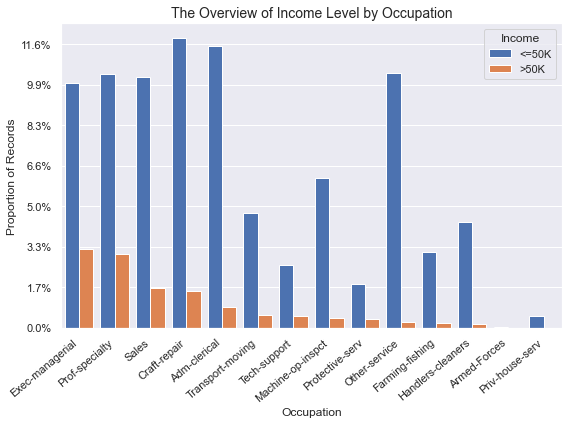

In [13]:
# Use occupation percentage of '>50K' as order of the plot
order = (ad_data.Occupation[ad_data.Income=='>50K'].value_counts()/ad_data.shape[0]).index

plt.figure(figsize=(8,6))
ax = sns.countplot(x = 'Occupation', hue = 'Income', order = order, data = ad_data, saturation=1)
ax.set_title('The Overview of Income Level by Occupation', fontsize = 14)
ax.set_xlabel("Occupation")
ax.set_ylabel("Proportion of Records")

ax.set_xticklabels(ax.get_xticklabels(), rotation=40, ha="right")

total = ad_data.shape[0]*1.
ax.set_yticklabels(map('{:.1f}%'.format, 100*ax.yaxis.get_majorticklocs()/total))
ax.legend(loc=1, title='Income')

plt.tight_layout()
plt.show()

<ipython-input-14-31db0bf55fe1>:13: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(map('{:.1f}%'.format, 100*ax.yaxis.get_majorticklocs()/total))


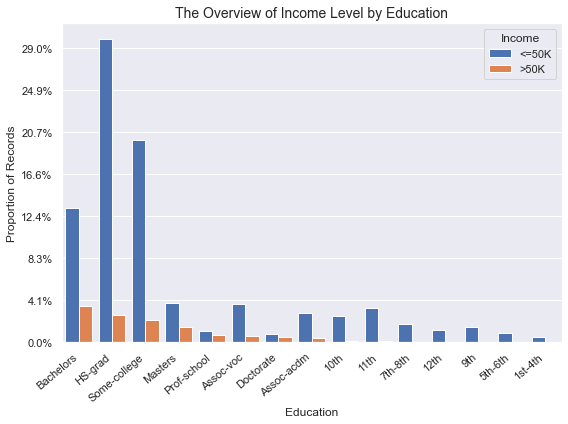

In [14]:
# Use occupation percentage of '>50K' as order of the plot
order = (ad_data.Education[ad_data.Income=='>50K'].value_counts()/ad_data.shape[0]).index

plt.figure(figsize=(8,6))
ax = sns.countplot(x = 'Education', hue = 'Income', order = order, data = ad_data, saturation=1)
ax.set_title('The Overview of Income Level by Education', fontsize = 14)
ax.set_xlabel("Education")
ax.set_ylabel("Proportion of Records")

ax.set_xticklabels(ax.get_xticklabels(), rotation=40, ha="right")

total = ad_data.shape[0]*1.
ax.set_yticklabels(map('{:.1f}%'.format, 100*ax.yaxis.get_majorticklocs()/total))
ax.legend(loc=1, title='Income')

plt.tight_layout()
plt.show()

In [15]:
# Total number of records
n_records = ad_data.shape[0]

# Number of records where individual's income is more than $50,000
n_greater_50k = np.sum(ad_data.Income=='>50K')

# Number of records where individual's incomre is less than $50,000
n_at_most_50k = np.sum(ad_data.Income=='<=50K')

# Percentage of indiciduals whose income is more than $50,000
greater_percentage = round(np.mean(ad_data.Income=='>50K')*100.00, 2)

# Print the results
print("Total number of records: {}".format(n_records))
print("Individuals Income more than $50K: {}".format(n_greater_50k))
print("Individuals Income at most $50K: {}".format(n_at_most_50k))
print("Percentage of Individuals Income more than $50K: {}%".format(greater_percentage))

Total number of records: 60323
Individuals Income more than $50K: 7508
Individuals Income at most $50K: 52815
Percentage of Individuals Income more than $50K: 12.45%


<AxesSubplot:>

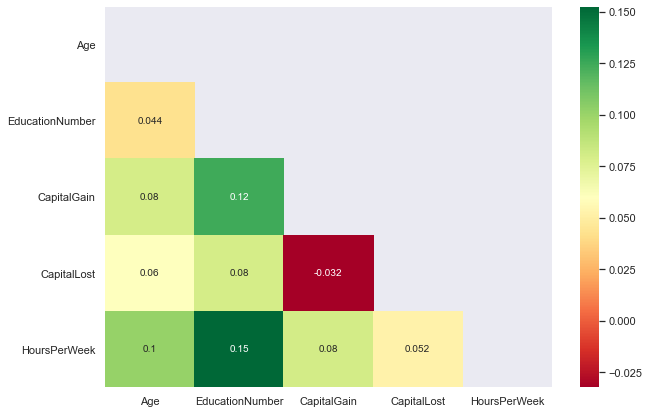

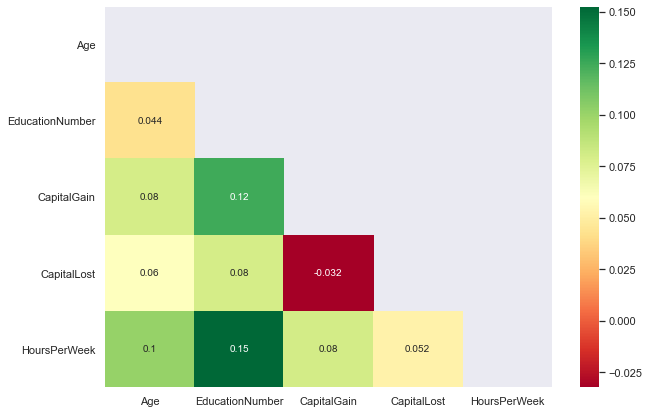

In [22]:
#Finding Correlation between variables

corr_train = ad_train.corr()
mask = np.zeros(corr_train.shape, dtype=bool)
mask[np.triu_indices(len(mask))] = True
plt.subplots(figsize=(10,7))
sns.heatmap(corr_train, xticklabels=corr_train.columns, yticklabels=corr_train.columns,annot=True,cmap='RdYlGn',mask = mask)

corr_test = ad_test.corr()
mask = np.zeros(corr_test.shape, dtype=bool)
mask[np.triu_indices(len(mask))] = True
plt.subplots(figsize=(10,7))
sns.heatmap(corr_test, xticklabels=corr_test.columns, yticklabels=corr_test.columns,annot=True,cmap='RdYlGn',mask = mask)

# Preparing Data

<ipython-input-23-da9e8e84c65b>:20: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


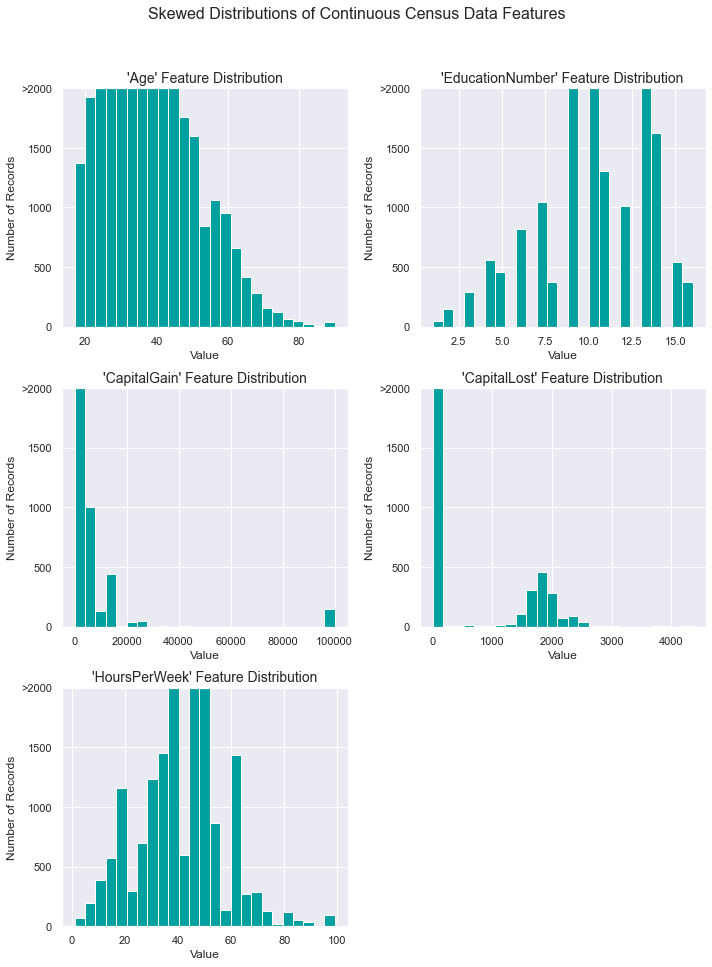

In [23]:
num_columns = ad_train.dtypes[ad_train.dtypes != 'object'].index

fig = plt.figure(figsize = (10,13));

# Skewed feature plotting
for i, feature in enumerate(ad_train[num_columns]):
    ax = fig.add_subplot(3, 2, i+1)
    ax.hist(ad_train[feature], bins = 25, color = '#00A0A0')
    ax.set_title("'%s' Feature Distribution"%(feature), fontsize = 14)
    ax.set_xlabel("Value")
    ax.set_ylabel("Number of Records")
    ax.set_ylim((0, 2000))
    ax.set_yticks([0, 500, 1000, 1500, 2000])
    ax.set_yticklabels([0, 500, 1000, 1500, ">2000"])

# Plot Aesthetics
fig.suptitle("Skewed Distributions of Continuous Census Data Features", fontsize = 16, y = 1.03)

fig.tight_layout()
fig.show()

In [24]:
# Calculate skew and sort
skew_feats = ad_train[num_columns].skew().sort_values(ascending=False)
skewness = pd.DataFrame({'Skew': skew_feats})
skewness

,Skew
CapitalGain,11.902682
CapitalLost,4.526380
Age,0.530228
HoursPerWeek,0.330869
EducationNumber,-0.305379


In [25]:
# Split the data into features and target label
income_raw = ad_train['Income']
feature_raw = ad_train.drop('Income', axis=1)

income_raw_test = ad_test['Income']
feature_raw_test = ad_test.drop('Income', axis=1)

# Log transform the skewed feature highly-skewed feature 'CapitalGain' and 'CapitalLost'. 
skewed = ['CapitalGain', 'CapitalLost']
features_log_transformed = pd.DataFrame(data=feature_raw)
features_log_transformed[skewed] = feature_raw[skewed].apply(lambda x: np.log(x + 1))

features_log_transformed_test = pd.DataFrame(data=feature_raw_test)
features_log_transformed_test[skewed] = feature_raw_test[skewed].apply(lambda x: np.log(x + 1))

In [26]:
# Initialize a scaler, then apply it to the features
scaler = MinMaxScaler()

features_log_minmax_transform = pd.DataFrame(data = features_log_transformed)
features_log_minmax_transform[num_columns] = scaler.fit_transform(features_log_transformed[num_columns])

# Transform the test data set
features_log_minmax_transform_test = pd.DataFrame(data = features_log_transformed_test)
features_log_minmax_transform_test[num_columns] = scaler.transform(features_log_transformed_test[num_columns])

# Show an example of a record with scaling applied
display(features_log_minmax_transform.head())
display(features_log_minmax_transform_test.head())

,Age,WorkClass,Education,EducationNumber,MaritalStatus,Occupation,Relationship,Race,Sex,CapitalGain,CapitalLost,HoursPerWeek,NativeCountry
0,0.301370,State-gov,Bachelors,0.800000,Never-married,Adm-clerical,Not-in-family,White,Male,0.667492,0.0,0.397959,United-States
1,0.452055,Self-emp-not-inc,Bachelors,0.800000,Married-civ-spouse,Exec-managerial,Husband,White,Male,0.000000,0.0,0.122449,United-States
2,0.287671,Private,HS-grad,0.533333,Divorced,Handlers-cleaners,Not-in-family,White,Male,0.000000,0.0,0.397959,United-States
3,0.493151,Private,11th,0.400000,Married-civ-spouse,Handlers-cleaners,Husband,Black,Male,0.000000,0.0,0.397959,United-States
4,0.150685,Private,Bachelors,0.800000,Married-civ-spouse,Prof-specialty,Wife,Black,Female,0.000000,0.0,0.397959,Cuba


,Age,WorkClass,Education,EducationNumber,MaritalStatus,Occupation,Relationship,Race,Sex,CapitalGain,CapitalLost,HoursPerWeek,NativeCountry
0,0.452055,Self-emp-not-inc,Bachelors,0.800000,Married-civ-spouse,Exec-managerial,Husband,White,Male,0.0,0.0,0.122449,United-States
1,0.287671,Private,HS-grad,0.533333,Divorced,Handlers-cleaners,Not-in-family,White,Male,0.0,0.0,0.397959,United-States
2,0.493151,Private,11th,0.400000,Married-civ-spouse,Handlers-cleaners,Husband,Black,Male,0.0,0.0,0.397959,United-States
3,0.150685,Private,Bachelors,0.800000,Married-civ-spouse,Prof-specialty,Wife,Black,Female,0.0,0.0,0.397959,Cuba
4,0.273973,Private,Masters,0.866667,Married-civ-spouse,Exec-managerial,Wife,White,Female,0.0,0.0,0.397959,United-States


# Preprocessing Data

In [27]:
#Check if any missing or unique value

In [28]:
cat_feats = features_log_minmax_transform.dtypes[features_log_minmax_transform.dtypes=='object'].index.tolist()
cat_idx = [features_log_minmax_transform.columns.get_loc(col) for col in cat_feats]

# Create the encoder.
encoder = OneHotEncoder(handle_unknown="ignore", sparse=False)

# Fit and transform the encoder on categorical features
encoded_cat_feats = encoder.fit_transform(features_log_minmax_transform.loc[:,cat_feats])

# Extract one-hot-encoder's feature names
cat_col_name = features_log_minmax_transform.columns.to_numpy()[cat_idx].tolist()
encoded_cat_feats_name = encoder.get_feature_names(cat_col_name)

# Generate OHE dataframe and concatenate it with the numerical dataframe later
encoded_cat_feats_df = pd.DataFrame(encoded_cat_feats, columns=encoded_cat_feats_name)
encoded_cat_feats_df.head()

,WorkClass_Federal-gov,WorkClass_Local-gov,WorkClass_Private,WorkClass_Self-emp-inc,WorkClass_Self-emp-not-inc,WorkClass_State-gov,WorkClass_Without-pay,Education_10th,Education_11th,Education_12th,...,NativeCountry_Portugal,NativeCountry_Puerto-Rico,NativeCountry_Scotland,NativeCountry_South,NativeCountry_Taiwan,NativeCountry_Thailand,NativeCountry_Trinadad&Tobago,NativeCountry_United-States,NativeCountry_Vietnam,NativeCountry_Yugoslavia
0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
1,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
2,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
3,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
4,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [29]:
# Apply OHE above to transform the test dataset
encoded_cat_feats_test = encoder.transform(features_log_minmax_transform_test.loc[:,cat_feats])

# Generate OHE dataframe and concatenate it with the numerical dataframe later
encoded_cat_feats_df_test = pd.DataFrame(encoded_cat_feats_test, columns=encoded_cat_feats_name)
encoded_cat_feats_df_test.head()

,WorkClass_Federal-gov,WorkClass_Local-gov,WorkClass_Private,WorkClass_Self-emp-inc,WorkClass_Self-emp-not-inc,WorkClass_State-gov,WorkClass_Without-pay,Education_10th,Education_11th,Education_12th,...,NativeCountry_Portugal,NativeCountry_Puerto-Rico,NativeCountry_Scotland,NativeCountry_South,NativeCountry_Taiwan,NativeCountry_Thailand,NativeCountry_Trinadad&Tobago,NativeCountry_United-States,NativeCountry_Vietnam,NativeCountry_Yugoslavia
0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
1,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
2,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
3,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0


In [30]:
# Extract the dataframe with only numerical features
num_feats_df = features_log_minmax_transform[num_columns].reset_index()

# Concatenate numerical and encoded categorical features together
x_train = pd.merge(num_feats_df, encoded_cat_feats_df, left_index=True, right_index=True).drop('index', axis=1)

# Encode the 'income_raw' to numerical values
y_train = income_raw.apply(lambda x: 1 if x == '>50K' else 0)

print("{} total features after one-hot encoding.".format(len(x_train.columns)))

# Display several rows of processed dataframe
x_train.head()

103 total features after one-hot encoding.


,Age,EducationNumber,CapitalGain,CapitalLost,HoursPerWeek,WorkClass_Federal-gov,WorkClass_Local-gov,WorkClass_Private,WorkClass_Self-emp-inc,WorkClass_Self-emp-not-inc,...,NativeCountry_Portugal,NativeCountry_Puerto-Rico,NativeCountry_Scotland,NativeCountry_South,NativeCountry_Taiwan,NativeCountry_Thailand,NativeCountry_Trinadad&Tobago,NativeCountry_United-States,NativeCountry_Vietnam,NativeCountry_Yugoslavia
0,0.301370,0.800000,0.667492,0.0,0.397959,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
1,0.452055,0.800000,0.000000,0.0,0.122449,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
2,0.287671,0.533333,0.000000,0.0,0.397959,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
3,0.493151,0.400000,0.000000,0.0,0.397959,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
4,0.150685,0.800000,0.000000,0.0,0.397959,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [31]:
# Do the same transformation on test data
# Extract the dataframe with only numerical features
num_feats_df_test = features_log_minmax_transform_test[num_columns].reset_index()

# Concatenate numerical and encoded categorical features together
x_test = pd.merge(num_feats_df_test, encoded_cat_feats_df_test, left_index=True, right_index=True)\
            .drop('index', axis=1)

# Encode the 'income_raw' to numerical values
y_test = income_raw_test.apply(lambda x: 1 if x == '>50K' else 0)

print("{} total features after one-hot encoding.".format(len(x_test.columns)))

# Display several rows of processed dataframe
x_test.head()

103 total features after one-hot encoding.


,Age,EducationNumber,CapitalGain,CapitalLost,HoursPerWeek,WorkClass_Federal-gov,WorkClass_Local-gov,WorkClass_Private,WorkClass_Self-emp-inc,WorkClass_Self-emp-not-inc,...,NativeCountry_Portugal,NativeCountry_Puerto-Rico,NativeCountry_Scotland,NativeCountry_South,NativeCountry_Taiwan,NativeCountry_Thailand,NativeCountry_Trinadad&Tobago,NativeCountry_United-States,NativeCountry_Vietnam,NativeCountry_Yugoslavia
0,0.452055,0.800000,0.0,0.0,0.122449,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
1,0.287671,0.533333,0.0,0.0,0.397959,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
2,0.493151,0.400000,0.0,0.0,0.397959,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
3,0.150685,0.800000,0.0,0.0,0.397959,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.273973,0.866667,0.0,0.0,0.397959,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0


In [32]:
# Calculate accuracy, precision and recall
accuracy = np.sum(y_train)/ y_train.count()
recall = np.sum(y_train) / np.sum(y_train)
precision = np.sum(y_train) / y_train.count()

# Calculate F-score using beta = 0.5 and correct values for precision and recall.
fscore = (1 + 0.5*0.5)* precision* recall/ (0.5*0.5*precision + recall)

print("Naive Predictor: [Accuracy score: {:.4f}, F-score: {:.4f}]".format(accuracy, fscore))

Naive Predictor: [Accuracy score: 0.2489, F-score: 0.2929]


# Build Data Model and Model Selection

# 1) Classification Model 

In [33]:
def train_predict(learner, sample_size, x_train, y_train, x_test, y_test): 
    '''
    inputs:
       - learner: the learning algorithm to be trained and predicted on
       - sample_size: the size of samples (number) to be drawn from training set
       - x_train: features training set
       - y_train: income training set
       - X_test: features testing set
       - y_test: income testing set
    '''
    
    results = {}
    
    # Fit the learner to the training data using slicing with 'sample_size' 
    start = time() # Get start time
    learner =  learner.fit(x_train[:sample_size], y_train[:sample_size])
    end = time() # Get end time
    
    # Calculate the training time
    results['train_time'] = end - start
        
    # Get the predictions on the test set(x_test),
    # then get predictions on the first 300 training samples(x_train) using .predict()
    start = time() # Get start time
    predictions_test = learner.predict(x_test)
    predictions_train = learner.predict(x_train[:300])
    end = time() # Get end time
    
    # Calculate the total prediction time
    results['pred_time'] = end - start
            
    # Compute accuracy on the first 300 training samples which is y_train[:300]
    results['acc_train'] = accuracy_score(y_train[:300], predictions_train)
        
    # Compute accuracy on test set using accuracy_score()
    results['acc_test'] = accuracy_score(y_test, predictions_test)
    
    # Compute F-score on the the first 300 training samples using fbeta_score()
    results['f_train'] = fbeta_score(y_train[:300], predictions_train, average = 'binary', beta = 0.5)
        
    # Compute F-score on the test set which is y_test
    results['f_test'] = fbeta_score(y_test, predictions_test, average = 'binary', beta = 0.5)
       
    # Success
    print("{} trained on {} samples.".format(learner.__class__.__name__, sample_size))
        
    # Return the results
    return results

In [34]:
# Initialize the models
clf_A = LogisticRegression(random_state = 42)
clf_B = RandomForestClassifier(random_state=42)
clf_C = AdaBoostClassifier(random_state = 42)
clf_D = SVC(random_state = 42)


# Calculate the number of samples for 1%, 10%, and 100% of the training data
samples_100 = int(len(x_train))
samples_10 = int(len(x_train) / 10)
samples_1 = int(len(x_train) / 100)

# Collect results on the learners
results = {}
for clf in [clf_A, clf_B, clf_C, clf_D]:
    clf_name = clf.__class__.__name__
    results[clf_name] = {}
    for i, samples in enumerate([samples_1, samples_10, samples_100]):
        results[clf_name][i] = \
        train_predict(clf, samples, x_train, y_train, x_test, y_test)

LogisticRegression trained on 301 samples.
LogisticRegression trained on 3016 samples.


C:\Users\jjpoh\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
C:\Users\jjpoh\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_

LogisticRegression trained on 30162 samples.
RandomForestClassifier trained on 301 samples.
RandomForestClassifier trained on 3016 samples.
RandomForestClassifier trained on 30162 samples.
AdaBoostClassifier trained on 301 samples.
AdaBoostClassifier trained on 3016 samples.
AdaBoostClassifier trained on 30162 samples.
SVC trained on 301 samples.
SVC trained on 3016 samples.
SVC trained on 30162 samples.


In [35]:
for i in results.items():
    print (i[0])
    display(pd.DataFrame(i[1]).rename(columns={0:'1%', 1:'10%', 2:'100%'}))

LogisticRegression


,1%,10%,100%
train_time,0.023514,0.064891,1.110289
pred_time,0.012181,0.000000,0.026803
acc_train,0.843333,0.826667,0.823333
acc_test,0.826133,0.788203,0.794039
f_train,0.688525,0.644699,0.637982
f_test,0.000000,0.000000,0.000000


RandomForestClassifier


,1%,10%,100%
train_time,0.134378,0.344792,5.115594
pred_time,0.314929,0.506224,0.682713
acc_train,1.000000,0.990000,0.980000
acc_test,0.839992,0.780279,0.757733
f_train,1.000000,0.975610,0.951743
f_test,0.000000,0.000000,0.000000


AdaBoostClassifier


,1%,10%,100%
train_time,0.047360,0.274928,2.266207
pred_time,0.655013,0.632805,0.652945
acc_train,0.913333,0.853333,0.850000
acc_test,0.801233,0.785120,0.801598
f_train,0.840841,0.702006,0.700935
f_test,0.000000,0.000000,0.000000


SVC


,1%,10%,100%
train_time,0.011436,0.350895,57.162108
pred_time,0.435343,2.957531,28.185524
acc_train,0.863333,0.833333,0.833333
acc_test,0.880375,0.802261,0.797255
f_train,0.777778,0.661538,0.659026
f_test,0.000000,0.000000,0.000000


<ipython-input-36-464e3b1d647b>:60: UserWarning: Tight layout not applied. tight_layout cannot make axes height small enough to accommodate all axes decorations
  fig.tight_layout()
<ipython-input-36-464e3b1d647b>:61: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


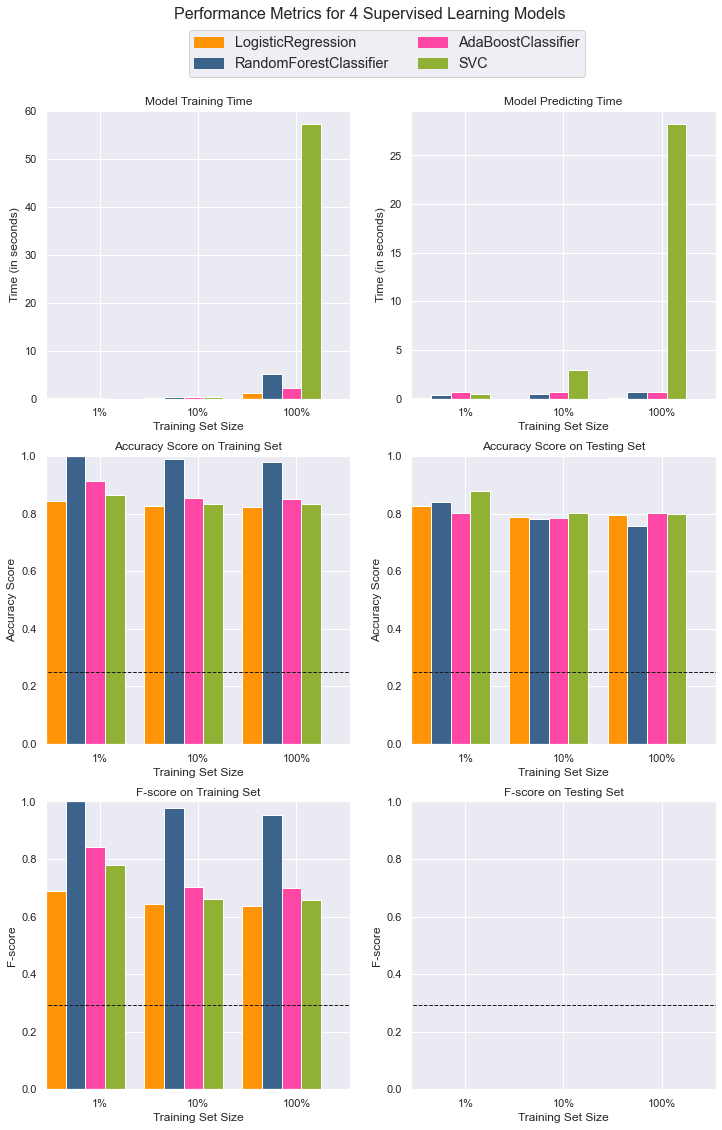

In [36]:
# Run metrics visualization for the 4 supervised learning models chosen

# Create figure
fig, ax = plt.subplots(3, 2, figsize = (12,18))

# Constants
bar_width = 0.2
colors =  ['#ff9408', '#3b638c', '#fe46a5', '#90b134']

# Super loop to plot four panels of data
for k, learner in enumerate(results.keys()):
    for j, metric in enumerate(['train_time','pred_time', 'acc_train', 'acc_test', 'f_train', 'f_test']):
        for i in np.arange(3):
                
            # Creative plot code
            ax[j//2, j%2].bar(i+k*bar_width, results[learner][i][metric], width = bar_width, color = colors[k])
            ax[j//2, j%2].set_xticks([0.45, 1.45, 2.45])
            ax[j//2, j%2].set_xticklabels(["1%", "10%", "100%"])
            ax[j//2, j%2].set_xlabel("Training Set Size")
            ax[j//2, j%2].set_xlim((-0.1, 3.0))
    
# Add y-labels
ax[0, 0].set_ylabel("Time (in seconds)")
ax[0, 1].set_ylabel("Time (in seconds)" )
ax[1, 0].set_ylabel("Accuracy Score")
ax[1, 1].set_ylabel("Accuracy Score")
ax[2, 0].set_ylabel("F-score")
ax[2, 1].set_ylabel("F-score")
    
# Add titles
ax[0, 0].set_title("Model Training Time")
ax[0, 1].set_title("Model Predicting Time")
ax[1, 0].set_title("Accuracy Score on Training Set")
ax[1, 1].set_title("Accuracy Score on Testing Set")
ax[2, 0].set_title("F-score on Training Set")
ax[2, 1].set_title("F-score on Testing Set")
    
# Add horizontal lines for naive predictors
ax[1, 0].axhline(y = accuracy, xmin = -0.1, xmax = 3.0, linewidth = 1, color = 'k', linestyle = 'dashed')
ax[1, 1].axhline(y = accuracy, xmin = -0.1, xmax = 3.0, linewidth = 1, color = 'k', linestyle = 'dashed')
ax[2, 0].axhline(y = fscore, xmin = -0.1, xmax = 3.0, linewidth = 1, color = 'k', linestyle = 'dashed')
ax[2, 1].axhline(y = fscore, xmin = -0.1, xmax = 3.0, linewidth = 1, color = 'k', linestyle = 'dashed')
    
# Set y-limits for score panels
ax[1, 0].set_ylim((0, 1))
ax[1, 1].set_ylim((0, 1))
ax[2, 0].set_ylim((0, 1))
ax[2, 1].set_ylim((0, 1))

# Create patches for the legend
patches = []
for i, learner in enumerate(results.keys()):
    patches.append(mpatches.Patch(color = colors[i], label = learner))
plt.legend(handles = patches, bbox_to_anchor = (-0.08, 3.68), \
            loc = 'upper center', borderaxespad = 0., ncol = 2, fontsize = 'x-large')
    
# Aesthetics
plt.suptitle("Performance Metrics for 4 Supervised Learning Models", fontsize = 16, y = 0.96)

fig.tight_layout()
fig.show()

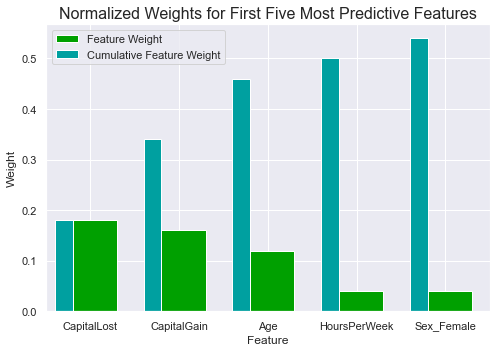

In [37]:
#Feature Importance

# Train the supervised model on the training set using .fit(x_train, y_train)
model = AdaBoostClassifier(random_state=42).fit(x_train, y_train)

# Extract the feature importances using .feature_importances_ 
importances = model.feature_importances_

# Display the five most important features
indices = np.argsort(importances)[::-1]
columns = x_train.columns.values[indices[:5]]
values = importances[indices][:5]

# Creat the plot
fig = plt.figure(figsize = (7,5))
plt.title("Normalized Weights for First Five Most Predictive Features", fontsize = 16)
plt.bar(np.arange(5), values, width = 0.6, align="center", color = '#00A000', label = "Feature Weight")
plt.bar(np.arange(5) - 0.3, np.cumsum(values), width = 0.2, align = "center", color = '#00A0A0', \
        label = "Cumulative Feature Weight")
plt.xticks(np.arange(5), columns)
plt.xlim((-0.5, 4.5))
plt.ylabel("Weight", fontsize = 12)
plt.xlabel("Feature", fontsize = 12)
    
plt.legend(loc = 'upper left')
plt.tight_layout()
plt.show()  

# 2) Clustering Model

In [38]:
feature_all = ad_data.drop('Income', axis=1)
features_log_transformed_all = pd.DataFrame(data=feature_all)
features_log_transformed_all[skewed] = feature_all[skewed].apply(lambda x: np.log(x + 1))

# Initialize a scaler, then apply it to the features
scaler = MinMaxScaler() # default=(0, 1)

features_log_minmax_transform_all = pd.DataFrame(data = features_log_transformed_all)
features_log_minmax_transform_all[num_columns] = scaler.fit_transform(features_log_transformed_all[num_columns])

# Apply OHE above to transform the test dataset
encoded_cat_feats_all = encoder.transform(features_log_minmax_transform_all.loc[:,cat_feats])

# Generate OHE dataframe and concatenate it with the numerical dataframe later
encoded_cat_feats_df_all = pd.DataFrame(encoded_cat_feats_all, columns=encoded_cat_feats_name)

# Extract the dataframe with only numerical features
num_feats_df_all = features_log_minmax_transform_all[num_columns].reset_index()

# Concatenate numerical and encoded categorical features together
ad_data_processed = pd.merge(num_feats_df_all, encoded_cat_feats_df_all, left_index=True, right_index=True)\
                        .drop('index', axis=1)

scaler2 = StandardScaler()
ad_data_processed[x_train.columns] = scaler2.fit_transform(ad_data_processed[x_train.columns].to_numpy())
ad_data_processed.head()

,Age,EducationNumber,CapitalGain,CapitalLost,HoursPerWeek,WorkClass_Federal-gov,WorkClass_Local-gov,WorkClass_Private,WorkClass_Self-emp-inc,WorkClass_Self-emp-not-inc,...,NativeCountry_Portugal,NativeCountry_Puerto-Rico,NativeCountry_Scotland,NativeCountry_South,NativeCountry_Taiwan,NativeCountry_Thailand,NativeCountry_Trinadad&Tobago,NativeCountry_United-States,NativeCountry_Vietnam,NativeCountry_Yugoslavia
0,0.042796,1.128940,2.809841,-0.222717,-0.077735,-0.17965,-0.271244,-1.682198,-0.192154,-0.300564,...,-0.033594,-0.060224,-0.019101,-0.048575,-0.037342,-0.023748,-0.024437,0.310873,-0.046113,-0.023038
1,0.880282,1.128940,-0.300984,-0.222717,-2.331513,-0.17965,-0.271244,-1.682198,-0.192154,3.327075,...,-0.033594,-0.060224,-0.019101,-0.048575,-0.037342,-0.023748,-0.024437,0.310873,-0.046113,-0.023038
2,-0.033339,-0.439720,-0.300984,-0.222717,-0.077735,-0.17965,-0.271244,0.594461,-0.192154,-0.300564,...,-0.033594,-0.060224,-0.019101,-0.048575,-0.037342,-0.023748,-0.024437,0.310873,-0.046113,-0.023038
3,1.108687,-1.224051,-0.300984,-0.222717,-0.077735,-0.17965,-0.271244,0.594461,-0.192154,-0.300564,...,-0.033594,-0.060224,-0.019101,-0.048575,-0.037342,-0.023748,-0.024437,0.310873,-0.046113,-0.023038
4,-0.794689,1.128940,-0.300984,-0.222717,-0.077735,-0.17965,-0.271244,0.594461,-0.192154,-0.300564,...,-0.033594,-0.060224,-0.019101,-0.048575,-0.037342,-0.023748,-0.024437,-3.216744,-0.046113,-0.023038


In [39]:
pca = PCA()
model = pca.fit_transform(ad_data_processed)

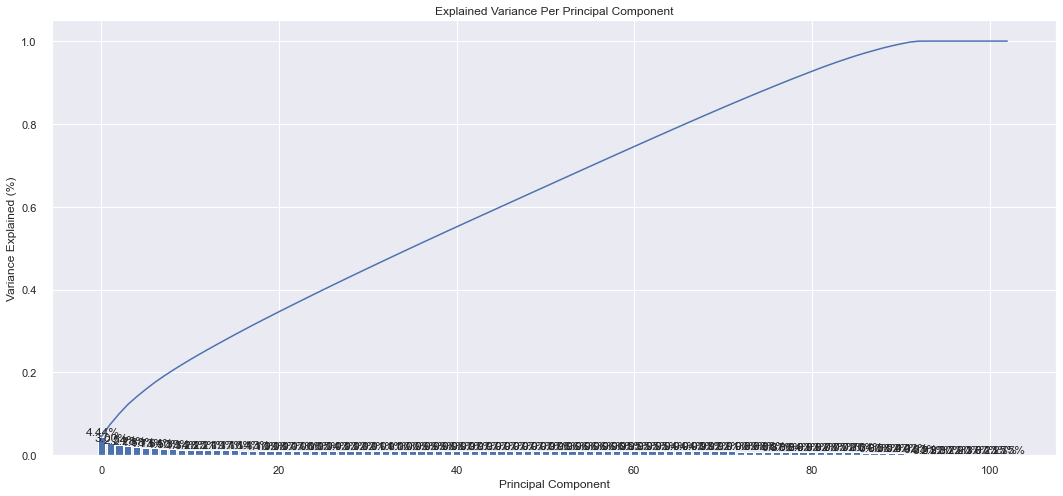

In [40]:
def plot_pc(pca):
    '''
    Creates a scree plot associated with the principal components 
    
    INPUT: pca - the result of instantian of PCA in scikit learn
            
    OUTPUT: None
    '''
    num_components=len(pca.explained_variance_ratio_)
    ind = np.arange(num_components)
    vals = pca.explained_variance_ratio_
 
    plt.figure(figsize=(18, 8))
    ax = plt.subplot(111)
    cumvals = np.cumsum(vals)
    ax.bar(ind, vals)
    ax.plot(ind, cumvals)
    for i in range(num_components):
        ax.annotate(r"%s%%" % ((str(vals[i]*100)[:4])), (ind[i]+0.2, vals[i]), va="bottom", ha="center", fontsize=12)
 
    ax.xaxis.set_tick_params(width=0)
    ax.yaxis.set_tick_params(width=2, length=12)
 
    ax.set_xlabel("Principal Component")
    ax.set_ylabel("Variance Explained (%)")
    plt.title('Explained Variance Per Principal Component')
    
plot_pc(pca)

In [41]:
# Find appropriate number of components to retain
start = time()
for i in np.arange(20, len(pca.explained_variance_ratio_), 3):
    print('For {} components, explained variance:'.format(i), 
          pca.explained_variance_ratio_[:i].sum())
end = time()
print(end - start)

For 20 components, explained variance: 0.33556990978590734
For 23 components, explained variance: 0.3679315774198353
For 26 components, explained variance: 0.3997266548403755
For 29 components, explained variance: 0.43088368622889434
For 32 components, explained variance: 0.46157208012058837
For 35 components, explained variance: 0.4919030837508572
For 38 components, explained variance: 0.5218405701329144
For 41 components, explained variance: 0.5514193772008105
For 44 components, explained variance: 0.5807370787105423
For 47 components, explained variance: 0.6099397897687409
For 50 components, explained variance: 0.6391016306606256
For 53 components, explained variance: 0.668220238867723
For 56 components, explained variance: 0.6972726588867484
For 59 components, explained variance: 0.7262033997006644
For 62 components, explained variance: 0.7549440581176383
For 65 components, explained variance: 0.7834941076883578
For 68 components, explained variance: 0.8117245243903871
For 71 compo

In [42]:
pca = PCA(n_components=80)
pca_80 = pca.fit_transform(ad_data_processed)

In [43]:
# Define a function to show the weight of each features by dimension
def show_weight(full_dataset, pca, comp_n, feat_n):
    '''
    Display the weight of each feature in dimension i
    INPUT: 
        full_dataset: dataset
        pca: PCA model fitted with data
        comp_n: index of component
        feat_n: feature number
    OUTPUT: weight of each feature 
    '''
    components = pd.DataFrame(np.round(pca.components_, 4), columns=full_dataset.keys()).iloc[comp_n - 1]
    components.sort_values(ascending=False, inplace=True)
    top2n_components = pd.concat([components.head(feat_n), components.tail(feat_n)])

    # Plot the result
    top2n_components.plot(kind='bar', 
                          title='Top {} weighted features for PCA component {}'.format(feat_n*2, comp_n),
                          figsize=(12, 6))
    plt.show()
#     top_components = pd.concat([components.iloc[:5,:],components.iloc[-5:]]).reset_index()
    return top2n_components

In [44]:
def get_kmeans_score(data, center):
    '''
    return the kmeans score regarding SSE for points to centers
    INPUT:
        data - the dataset you want to fit kmeans to
        center - the number of centers you want
    OUTPUT:
        score - the SSE score for the kmeans model fit to the data
    '''
    # instantiate kmeans
    kmeans = KMeans(n_clusters=center)
    
    # Then fit the model to you data using the fit mothod
    model = kmeans.fit(data)
    
    # Obtain a score related to the model fit
    score = np.abs(model.score(data))
    
    return score

In [45]:
scores = []
centers = [1,2,3,4,5,6,7,8,9,10,11,12]

start = time()

for center in centers:
    print('Fitting k = {} '.format(center))
    scores.append(get_kmeans_score(pca_80, center))
end = time()

print("--- Run time: %s mins ---" % np.round(((end - start)/60),2))

Fitting k = 1 
Fitting k = 2 
Fitting k = 3 
Fitting k = 4 
Fitting k = 5 
Fitting k = 6 
Fitting k = 7 
Fitting k = 8 
Fitting k = 9 
Fitting k = 10 
Fitting k = 11 
Fitting k = 12 
--- Run time: 0.46 mins ---


Text(0.5, 1.0, 'SSE vs. K')

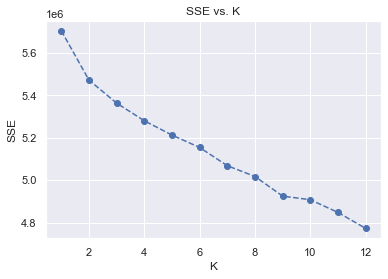

In [46]:
# Plot the SSE value to decide the K value
plt.plot(centers, scores, linestyle='--', marker='o', color='b')
plt.xlabel('K')
plt.ylabel('SSE')
plt.title('SSE vs. K')

In [47]:
# Re-fit the k-means model with the selected number of clusters and obtain
# cluster predictions for the general population demographics data.
kmeans = KMeans(n_clusters=2)
model = kmeans.fit(pca_80)

In [48]:
# Store the prediction
adult_predict = pd.DataFrame(np.array(model.predict(pca_80)), columns=['Prediction'])

# Count the cluster number
cluster_cnt = adult_predict['Prediction'].value_counts().sort_index()
display(cluster_cnt)

cluster_prop = pd.DataFrame((cluster_cnt/cluster_cnt.sum()), columns=['Prediction']).reset_index()
cluster_prop.set_index('index', inplace=True)
display(cluster_prop)

0    34979
1    25344
Name: Prediction, dtype: int64

,Prediction
index,
0,0.579862
1,0.420138


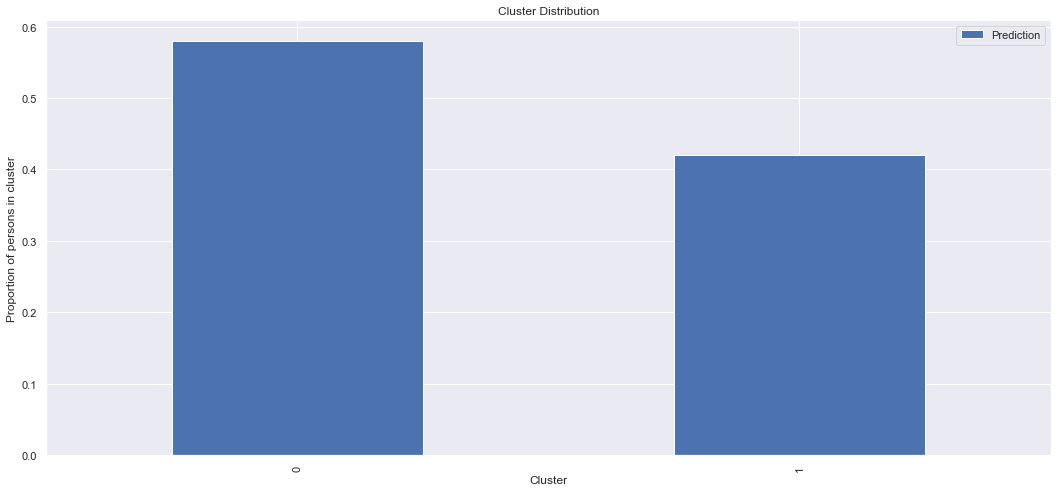

In [49]:
cluster_prop = cluster_prop.reset_index()
cluster_prop.plot(x = 'index', y = 'Prediction', kind = 'bar', figsize = (18,8))
plt.title('Cluster Distribution')
plt.xlabel('Cluster')
plt.ylabel('Proportion of persons in cluster')
plt.show()

In [50]:
cluster0_components = pd.Series(kmeans.cluster_centers_[0])
cluster0_components.sort_values(ascending=False, inplace=True)
cluster0_components.head(5)

5     0.152022
4     0.135233
7     0.067345
10    0.062547
18    0.045941
dtype: float64

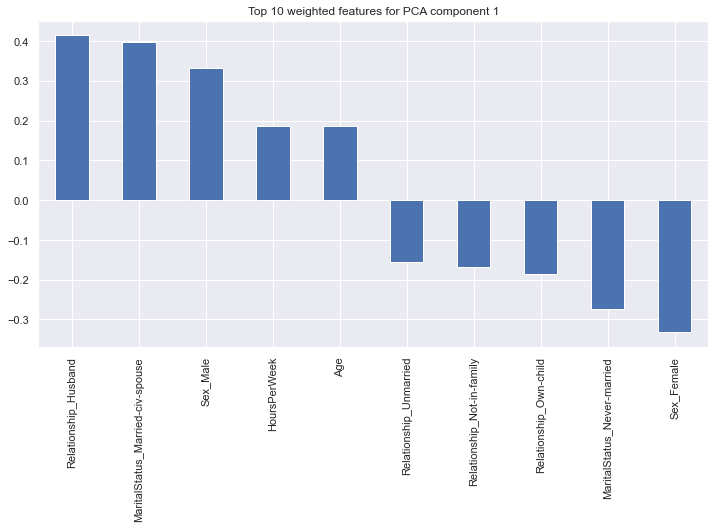

Relationship_Husband                0.4142
MaritalStatus_Married-civ-spouse    0.3969
Sex_Male                            0.3312
HoursPerWeek                        0.1872
Age                                 0.1852
Relationship_Unmarried             -0.1549
Relationship_Not-in-family         -0.1683
Relationship_Own-child             -0.1869
MaritalStatus_Never-married        -0.2743
Sex_Female                         -0.3312
Name: 0, dtype: float64

In [51]:
# To get the detail of cluster, transfer cluster back to analyze the principle component
cluster0 = scaler2.inverse_transform(pca.inverse_transform(pca_80))[adult_predict.Prediction==0]
cluster0_features = pd.DataFrame(data = np.round(cluster0), columns= ad_data_processed.columns)
# cluster0_features.head()

# Chenck top features in first component
show_weight(cluster0_features, pca, 1, 5)